In [314]:
from gensim.models.word2vec import Word2Vec
import numpy as np

import urllib3
import pandas as pd
import os
import gc
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

In [315]:
train=pd.read_csv('./data/onlyword2_train.csv')
test=pd.read_csv('./data/onlyword2_test.csv')
submission=pd.read_csv('./data/sample_submission.csv')

In [316]:
# train = pd.read_csv('./data/mask_test2/mask_train.csv')

In [317]:
train

,id,level,cut
0,0,0,collection connection error internal level liv...
1,1,0,action active audit code exception not primary...
2,2,0,collection connection error internal level liv...
3,3,0,collection connection error internal level liv...
4,4,1,arch audit bin cache date dev exit gid item ke...
...,...,...,...
472967,472967,0,error
472968,472968,1,arch audit bin boot cap dev exit gid grub item...
472969,472969,0,error for living log manager message poll task...
472970,472970,0,collection connection error internal level liv...


In [318]:
train['cut'][0]

'collection connection error internal level living message name next node pool process share stack tick transport type warning'

In [319]:
print(train.shape, test.shape, submission.shape)

(472972, 3) (1418916, 2) (1418916, 2)


In [320]:
# #full_log에서 숫자는 마스킹 처리
# train['full_log']=train['full_log'].str.replace(r'[0-9]', '<num>')
# test['full_log']=test['full_log'].str.replace(r'[0-9]', '<num>')

In [321]:
# #train full_log의 길이 확인
# train['full_log'].str.split(' ').str.len().hist(bins=50)

In [322]:
# train['level'].value_counts()

In [323]:
# train_text=list(train['full_log'][train['level'].isin([0,1])])
# train_level=np.array(train['level'][train['level'].isin([0,1])])

In [333]:
train_text=list(train['cut'].astype(str)[train['level'].isin([0,1,3,5])])

train_level=np.array(train['level'][train['level'].isin([0,1,3,5])])

In [334]:
# train_text=list(train['cut'].astype(str))
# train_level=np.array(train['level'])

In [335]:
# import re

# for i in train_text:
#     i = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', i)
# #     i = i.replace('Jan', '')
# #     i = i.replace('Feb', '')
# #     i = i.replace('Dec', '')
# #     i = i.replace('Sep', '')
# #     i = i.replace('Oct', '')
# #     i = i.replace('Nov', '')
# #     i = i.replace('Mar', '')
# #     i = i.sub('num', '', i)

In [336]:
maxlen = 100
embed_size = 30
max_features = 100

In [337]:
# #CountVectorizer로 벡터화
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer=CountVectorizer(analyzer="word", max_features=500)

# train_features=vectorizer.fit_transform(train_text)

In [338]:
# train_features

In [339]:
tokenizer = text.Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_text)

In [340]:
sequences = tokenizer.texts_to_sequences(train_text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2001 unique tokens.


In [341]:
word_index

{'<OOV>': 1,
 'type': 2,
 'error': 3,
 'name': 4,
 'message': 5,
 'living': 6,
 'pool': 7,
 'connection': 8,
 'warning': 9,
 'path': 10,
 'audit': 11,
 'key': 12,
 'exit': 13,
 'arch': 14,
 'gid': 15,
 'success': 16,
 'suid': 17,
 'yes': 18,
 'object': 19,
 'dev': 20,
 'mode': 21,
 'item': 22,
 'normal': 23,
 'node': 24,
 'system': 25,
 'none': 26,
 'share': 27,
 'transport': 28,
 'process': 29,
 'internal': 30,
 'next': 31,
 'tick': 32,
 'bin': 33,
 'unconfined': 34,
 'level': 35,
 'stack': 36,
 'collection': 37,
 'cap': 38,
 'service': 39,
 'log': 40,
 'unreachable': 41,
 'for': 42,
 'but': 43,
 'warn': 44,
 'manticore': 45,
 'dead': 46,
 'instance': 47,
 'got': 48,
 'resurrect': 49,
 'manager': 50,
 'task': 51,
 'work': 52,
 'poll': 53,
 'not': 54,
 'bash': 55,
 'file': 56,
 'the': 57,
 'request': 58,
 'cache': 59,
 'port': 60,
 'exception': 61,
 'root': 62,
 'from': 63,
 'active': 64,
 'scan': 65,
 'bad': 66,
 'classification': 67,
 'potentially': 68,
 'priority': 69,
 'suspicious'

메일의 최대 길이 : 123
메일의 평균 길이 : 14.981831


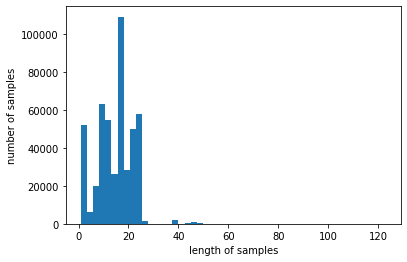

In [342]:
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [343]:
maxlen = max(len(l) for l in X_data)
maxlen

123

In [609]:
maxlen = 50

In [610]:
data = pad_sequences(sequences, maxlen=maxlen)

In [611]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.05
RANDOM_SEED=42

X_train, X_test, y_train, y_test = train_test_split(data, train_level, test_size=TEST_SIZE, random_state=RANDOM_SEED)


In [612]:
X_train

array([[  0,   0,   0, ..., 287,  41,  86],
       [  0,   0,   0, ...,   2,  41,  44],
       [  0,   0,   0, ...,   2,  41,  44],
       ...,
       [  0,   0,   0, ...,  28,   2,   9],
       [  0,   0,   0, ...,   2,  34,  18],
       [  0,   0,   0, ...,  28,   2,   9]])

In [613]:
train_df = pd.DataFrame(X_train)
train_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,0,0,0,0,0,0,0,0,...,5,268,7,130,58,87,84,287,41,86
1,0,0,0,0,0,0,0,0,0,0,...,46,3,48,47,45,7,49,2,41,44
2,0,0,0,0,0,0,0,0,0,0,...,46,3,48,47,45,7,49,2,41,44
3,0,0,0,0,0,0,0,0,0,0,...,23,19,10,39,16,17,25,2,34,18
4,0,0,0,0,0,0,0,0,0,0,...,3,42,6,40,50,5,53,51,2,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,101
449290,0,0,0,0,0,0,0,0,0,0,...,3,42,6,40,50,5,53,51,2,52
449291,0,0,0,0,0,0,0,0,0,0,...,31,24,7,29,27,36,32,28,2,9
449292,0,0,0,0,0,0,0,0,0,0,...,23,19,10,39,16,17,25,2,34,18


In [614]:
columns = train_df.columns

In [615]:
TAG_MIN = train_df[columns].min()
TAG_MAX = train_df[columns].max()

In [616]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [617]:
X_train = normalize(train_df[columns])
X_train

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002529,0.136526,0.003534,0.065261,0.029073,0.043544,0.043277,0.145096,0.020531,0.042021
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023268,0.001528,0.024230,0.023594,0.022556,0.003504,0.025245,0.001011,0.020531,0.021011
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023268,0.001528,0.024230,0.023594,0.022556,0.003504,0.025245,0.001011,0.020531,0.021011
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011634,0.009679,0.005048,0.019578,0.008020,0.008509,0.012880,0.001011,0.017026,0.008004
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001517,0.021396,0.003029,0.020080,0.025063,0.002503,0.027306,0.025784,0.001002,0.025013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001502,0.049525
449290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001517,0.021396,0.003029,0.020080,0.025063,0.002503,0.027306,0.025784,0.001002,0.025013
449291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015680,0.012226,0.003534,0.014558,0.013534,0.018018,0.016486,0.014156,0.001002,0.003502
449292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011634,0.009679,0.005048,0.019578,0.008020,0.008509,0.012880,0.001011,0.017026,0.008004


In [618]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.15
RANDOM_SEED=42

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_SEED)


In [619]:
X_train.shape, X_val.shape

((381899, 50), (67395, 50))

In [620]:
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_train.shape
# X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
# X_val.shape

In [621]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)


In [622]:
# def conv_auto_model(x):

#     n_steps = x.shape[1]
#     n_features = x.shape[2]


#     model = Sequential(
#         [
#             Input(shape=(n_steps, n_features)),
#             Conv1D(filters=64, kernel_size=16, padding='same', data_format='channels_last',
#                           dilation_rate=1, activation="linear"),
#             Dense(32),
#             LSTM(
#                 units=32, activation="relu", name="lstm_1", return_sequences=False
#             ),
#             RepeatVector(n_steps),
#             Conv1D(filters=64, kernel_size=16, padding='same', data_format='channels_last',
#                 dilation_rate=1, activation="linear"),
#             Dense(32),
#             LSTM(
#                 units=32, activation="relu", name="lstm_2", return_sequences=True
#             ),

#             TimeDistributed(Dense(n_features, activation='linear'))
#         ]
#     )

#     model.summary()
#     return model

In [645]:
from keras import regularizers
def dnn(x):
    input_dim = x.shape[1]
    input = Input(shape=(input_dim, ))
    
    encode = Dense(x.shape[1], activation='relu', activity_regularizer=regularizers.l1(10e-5))(input)
    #encode = Dense(x.shape[1], activation='relu')(encode)
    encode = Dense(x.shape[1]//2, activation='relu')(encode)
#     encode = Dense(x.shape[1]//4, activation='relu')(encode)
#     decode = Dense(x.shape[1]//4, activation='relu')(encode)
    decode = Dense(x.shape[1]//2, activation='relu')(encode)
    decode = Dense(x.shape[1], activation='relu')(decode)
    #decode = Dense(x.shape[1]*2, activation='relu')(decode)
    decode = Dense(x.shape[1], activation='relu')(decode)

    autoencoder = Model(input, decode)

    autoencoder.summary()
    
    return autoencoder

In [646]:
model = dnn(X_train)
model.compile(optimizer='adam', loss='mse')
#model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
modelpath = "./model/0,1_{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)


epochs = 30
batch = 64


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
dense_109 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_110 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_111 (Dense)            (None, 25)                650       
_________________________________________________________________
dense_112 (Dense)            (None, 50)                1300      
_________________________________________________________________
dense_113 (Dense)            (None, 50)                2550      
Total params: 8,325
Trainable params: 8,325
Non-trainable params: 0
________________________________________________________

In [647]:
# fit
history = model.fit(X_train, X_train,
                     epochs=epochs, batch_size=batch,
                     validation_data=(X_val, X_val), callbacks=[early_stopping, checkpointer])

Epoch 1/30
5968/5968 [==============================] - 5s 854us/step - loss: 1.6473e-04 - val_loss: 8.4234e-05

Epoch 00001: val_loss improved from inf to 0.00008, saving model to ./model\0,1_01-0.0001.hdf5
Epoch 2/30
5968/5968 [==============================] - 5s 820us/step - loss: 8.3425e-05 - val_loss: 7.0545e-05

Epoch 00002: val_loss improved from 0.00008 to 0.00007, saving model to ./model\0,1_02-0.0001.hdf5
Epoch 3/30
5968/5968 [==============================] - 5s 816us/step - loss: 7.4262e-05 - val_loss: 6.6294e-05

Epoch 00003: val_loss improved from 0.00007 to 0.00007, saving model to ./model\0,1_03-0.0001.hdf5
Epoch 4/30
5968/5968 [==============================] - 5s 819us/step - loss: 6.9132e-05 - val_loss: 6.0005e-05

Epoch 00004: val_loss improved from 0.00007 to 0.00006, saving model to ./model\0,1_04-0.0001.hdf5
Epoch 5/30
5968/5968 [==============================] - 5s 841us/step - loss: 6.1621e-05 - val_loss: 5.6023e-05

Epoch 00005: val_loss improved from 0.00006

In [648]:
model = load_model('./model/0,1_20-0.0000.hdf5')

In [649]:
val_sample = pd.read_csv('./data/onlyword2_valid.csv')
val_sample

,word1,cut
0,type,arch audit dev exit gid key none null old prom...
1,oscap,account and any anyone assigned authentication...
2,Sep l,child kernel kill memory out probe process sac...


In [650]:
# val_sample['full_log']=val_sample['full_log'].str.replace(r'[0-9]', '<num>')

In [651]:
val_sample['cut']

0    arch audit dev exit gid key none null old prom...
1    account and any anyone assigned authentication...
2    child kernel kill memory out probe process sac...
Name: cut, dtype: object

In [652]:
# for i in val_sample['full_log']:
#     i = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', i)
# #     i = i.replace('Jan', '')
# #     i = i.replace('Feb', '')
# #     i = i.replace('Dec', '')
# #     i = i.replace('Sep', '')
# #     i = i.replace('Oct', '')
# #     i = i.replace('Nov', '')
# #     i = i.replace('Mar', '')

In [653]:
val_smaple_data = tokenizer.texts_to_sequences(val_sample['cut'])
val_smaple_data = pad_sequences(val_smaple_data, maxlen=maxlen)

In [654]:
val_smaple_data.shape

(3, 50)

In [655]:

import pandas as pd
from numpy import vstack

# Combined x and x_test.
new_x = vstack([X_test, val_smaple_data])

In [656]:
len(new_x)

23651

In [657]:
new_x[-1:]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 1004,  281,  688,
         393,  268,  275,   29,    1, 1610]])

In [658]:
new_df = pd.DataFrame(new_x)
new_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,0,0,0,0,0,0,0,0,...,26,23,19,10,16,17,25,2,34,18
1,0,0,0,0,0,0,0,0,0,0,...,4,26,23,19,10,16,17,2,34,18
2,0,0,0,0,0,0,0,0,0,0,...,46,3,48,47,45,7,49,2,41,44
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,101
4,0,0,0,0,0,0,0,0,0,0,...,3,42,6,40,50,5,53,51,2,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23646,0,0,0,0,0,0,0,0,0,0,...,31,24,7,29,27,36,32,28,2,9
23647,0,0,0,0,0,0,0,0,0,0,...,46,3,48,47,45,7,49,2,41,44
23648,0,0,0,0,0,0,0,0,0,0,...,221,245,1,39,16,17,25,2,34,18
23649,1679,218,43,250,180,92,219,503,427,207,...,199,256,271,25,217,57,253,328,94,561


In [659]:
new_x = normalize(new_df[columns])
new_x

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.013151,0.011717,0.009591,0.005020,0.008020,0.008509,0.012880,0.001011,0.017026,0.008004
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.002023,0.013245,0.011610,0.009538,0.005013,0.008008,0.008758,0.001011,0.017026,0.008004
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.023268,0.001528,0.024230,0.023594,0.022556,0.003504,0.025245,0.001011,0.020531,0.021011
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001502,0.049525
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.001517,0.021396,0.003029,0.020080,0.025063,0.002503,0.027306,0.025784,0.001002,0.025013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.015680,0.012226,0.003534,0.014558,0.013534,0.018018,0.016486,0.014156,0.001002,0.003502
23647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.023268,0.001528,0.024230,0.023594,0.022556,0.003504,0.025245,0.001011,0.020531,0.021011
23648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.111786,0.124809,0.000505,0.019578,0.008020,0.008509,0.012880,0.001011,0.017026,0.008004
23649,1.282659,0.129608,0.027564,0.129938,0.110429,0.056966,0.137132,0.299049,0.27584,0.126916,...,0.100658,0.130413,0.136800,0.012550,0.108772,0.028529,0.130345,0.165824,0.047071,0.279640


In [660]:
y_val2 = np.zeros(len(y_test)+3)
y_val2[-1] = 1
y_val2[-2] = 1
y_val2[-3] = 1

y_val2

array([0., 0., 0., ..., 1., 1., 1.])

In [661]:
len(y_val2)

23651

In [662]:
predictions = model.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})


Text(0.5, 0, 'Data point index')

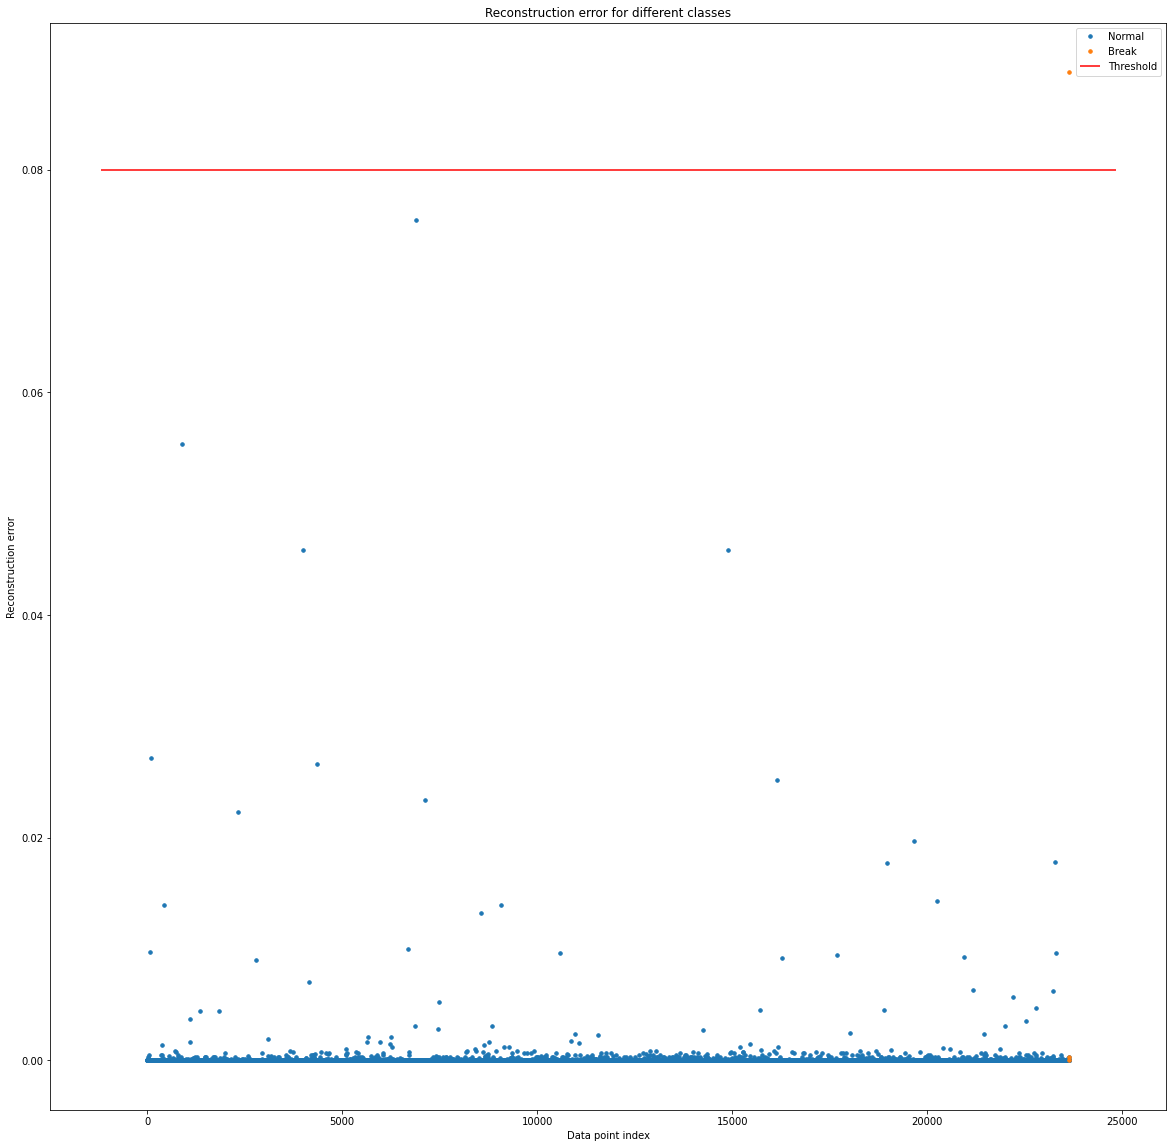

In [664]:
test_error_df = pd.DataFrame({'Reconstruction_error': list(error_df['reconstruction_error']),
                         'True_class': list(y_val2)})
groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")

#ax.hlines(0.0058, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.hlines(0.08, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(0.001, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(3, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [665]:
# #full_log에서 숫자는 마스킹 처리
# test['full_log']=test['full_log'].str.replace(r'[0-9]', '<num>')

In [666]:
# test = pd.read_csv('./data/mask_test2/mask_test.csv')


In [667]:
test_data = tokenizer.texts_to_sequences(test['cut'].astype(str))
test_data = sequence.pad_sequences(test_data, maxlen=maxlen)

In [668]:
new_df = pd.DataFrame(test_data)
new_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,143,162,149,155,146,37,148,184,...,157,154,32,28,144,2,74,164,9,183
1,0,0,0,0,0,0,0,0,0,0,...,31,24,7,29,27,36,32,28,2,9
2,0,0,0,0,0,0,0,0,0,0,...,19,10,199,39,16,17,25,2,34,18
3,0,0,0,0,0,0,0,0,0,0,...,31,24,7,29,27,36,32,28,2,9
4,0,0,0,0,0,0,0,0,0,0,...,4,26,23,19,10,16,17,25,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418911,0,0,0,0,0,0,0,0,0,0,...,31,24,7,29,27,36,32,28,2,9
1418912,0,0,0,0,0,0,0,0,0,0,...,3,42,6,40,50,5,53,51,2,52
1418913,0,0,0,0,0,0,0,0,0,0,...,26,23,19,10,16,17,25,2,34,18
1418914,0,0,0,0,0,0,0,0,0,0,...,46,3,48,47,45,7,49,2,41,44


In [669]:
test_data  =  normalize(new_df[columns])
test_data 

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.091667,0.0842,0.091411,0.095975,0.091421,0.021998,0.095607,0.112814,...,0.079413,0.078451,0.016153,0.014056,0.072180,0.001001,0.038125,0.082912,0.004507,0.090545
1,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015680,0.012226,0.003534,0.014558,0.013534,0.018018,0.016486,0.014156,0.001002,0.003502
2,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009611,0.005094,0.100454,0.019578,0.008020,0.008509,0.012880,0.001011,0.017026,0.008004
3,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015680,0.012226,0.003534,0.014558,0.013534,0.018018,0.016486,0.014156,0.001002,0.003502
4,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002023,0.013245,0.011610,0.009538,0.005013,0.008008,0.008758,0.012639,0.001002,0.008004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418911,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015680,0.012226,0.003534,0.014558,0.013534,0.018018,0.016486,0.014156,0.001002,0.003502
1418912,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001517,0.021396,0.003029,0.020080,0.025063,0.002503,0.027306,0.025784,0.001002,0.025013
1418913,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013151,0.011717,0.009591,0.005020,0.008020,0.008509,0.012880,0.001011,0.017026,0.008004
1418914,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.023268,0.001528,0.024230,0.023594,0.022556,0.003504,0.025245,0.001011,0.020531,0.021011


In [670]:
predictions = model.predict(test_data)

# Calculated MSE.
mse = np.mean(np.power(test_data  - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})


In [671]:
error_df

,reconstruction_error
0,4.924861e-04
1,6.190210e-07
2,2.338509e-05
3,6.190210e-07
4,7.600276e-06
...,...
1418911,6.190233e-07
1418912,4.842168e-07
1418913,6.472065e-06
1418914,2.371405e-07


In [672]:
pred_y_test = [1 if e > 0.08 else 0 for e in (error_df['reconstruction_error'].values)]
pred_y_test = np.array(pred_y_test)
pred_y_test.shape

(1418916,)

Text(0.5, 0, 'Data point index')

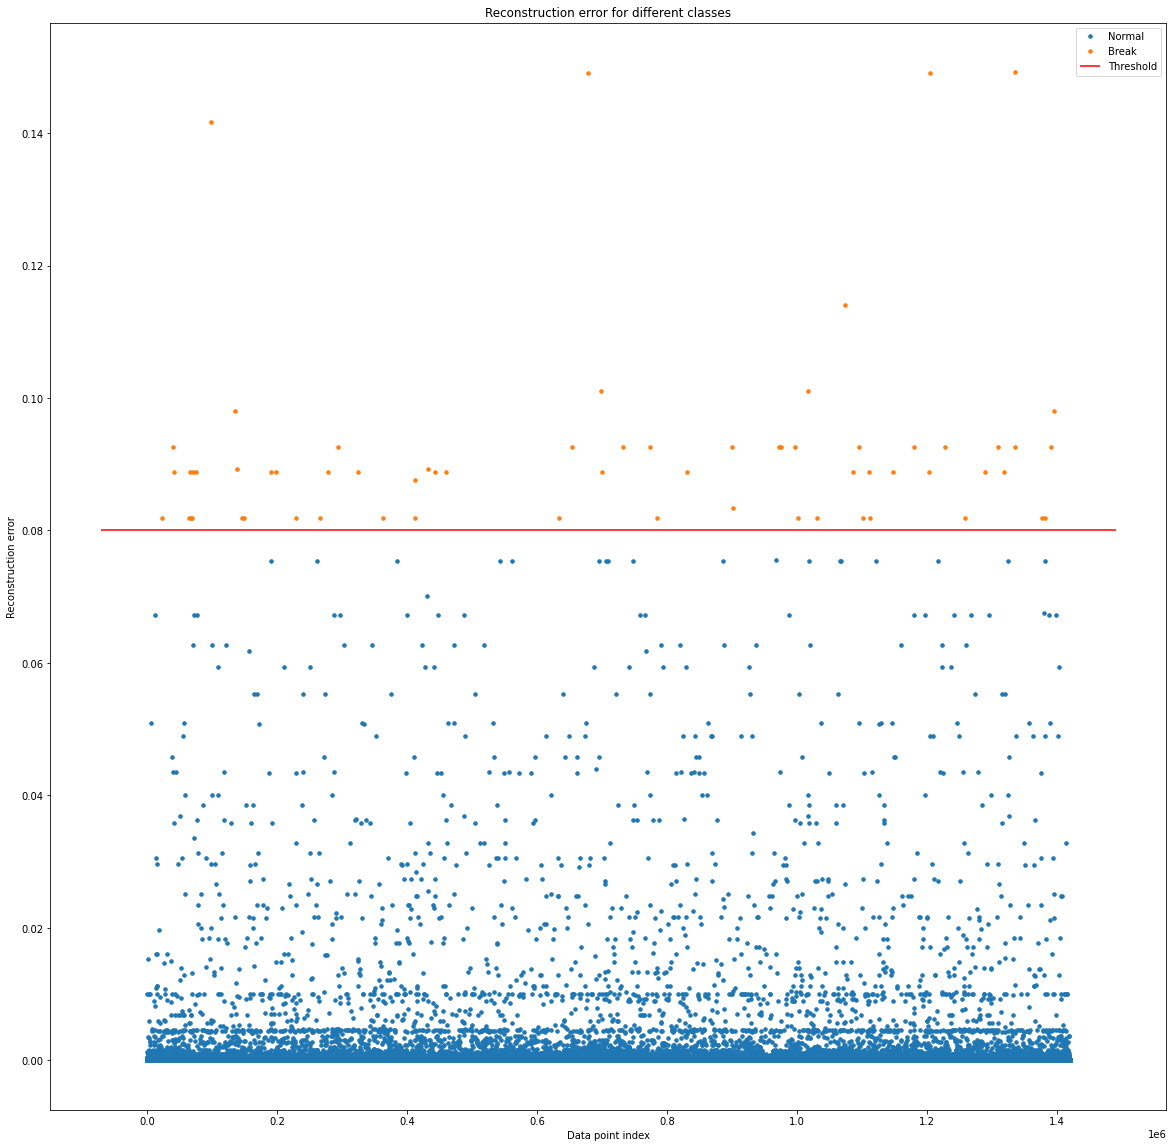

In [673]:
test_error_df = pd.DataFrame({'Reconstruction_error': list(error_df['reconstruction_error']),
                         'True_class': list(pred_y_test)})
groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")

#ax.hlines(0.012, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.hlines(0.08, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(0.001, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(3, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [674]:
test['predict'] = pred_y_test

In [675]:
test

,id,cut,predict
0,1000000,all anonymous body bool cause collection doc e...,0
1,1000001,collection connection error internal level liv...,0
2,1000002,arch audit bin cap dev exit gid item key mode ...,0
3,1000003,collection connection error internal level liv...,0
4,1000004,arch audit dev exit file gid item key mode nam...,0
...,...,...,...
1418911,2418911,collection connection error internal level liv...,0
1418912,2418912,error for living log manager message poll task...,0
1418913,2418913,arch audit bin cap dev exit file gid item key ...,0
1418914,2418914,but connection dead error got instance mantico...,0


In [676]:
test.to_csv('./test_cut_0.06.csv', index=False)

In [677]:
submission['level']=pred_y_test

In [678]:
submission

,id,level
0,1000000,0
1,1000001,0
2,1000002,0
3,1000003,0
4,1000004,0
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,0
1418914,2418914,0


In [679]:
submission['level'].value_counts()

0    1418851
1         65
Name: level, dtype: int64

In [680]:
submission.to_csv('./auto_65.csv', index=False)

In [308]:
submission = pd.read_csv('./submit/baseline_600.csv')

In [309]:
submission['level'].value_counts()

0    1002564
1     396474
3      12868
5       6248
7        669
4         34
2         34
6         25
Name: level, dtype: int64

In [310]:
for i in tqdm(range(len(submission))):
    if test['predict'][i] == 1:
        submission['level'][i] = 7

100%|███████████████████████████████████████████████████████████████| 1418916/1418916 [00:07<00:00, 183348.27it/s]


In [311]:
submission['level'].value_counts()

0    1002564
1     396461
3      12868
5       6234
7        696
4         34
2         34
6         25
Name: level, dtype: int64

In [312]:
submission.to_csv('./submit/baseline_600_79.csv', index=False)